In [ ]:
import os
import random

import astropy.units as u
import btk
import matplotlib.pyplot as plt
import yaml
from astropy.io import fits

from blendxpz.simulations.sampling import FixedDistSampling
from blendxpz.simulations.ssi import ssi_on_simulations
from blendxpz.utils import get_blendxpz_config_path

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
with open(get_blendxpz_config_path()) as f:
    blendxpz_config = yaml.safe_load(f)

In [ ]:
survey_name = blendxpz_config["SURVEY_NAME"]
config = blendxpz_config[survey_name]

### Get real HSC image

In [ ]:
coadd = random.choice(config["AVAILABLE_COADDS"])
image_dir = os.path.join(config["REAL_DATA_DIR"], coadd, "images")
gal_file_name = random.choice(os.listdir(image_dir))
gal_file_path = os.path.join(image_dir, gal_file_name)

In [ ]:
isolated_galaxy = fits.getdata(gal_file_path)

In [ ]:
# extract the same size as the stamp
stamp_pixel_size = config["STAMP_PIXEL_SIZE"]
size = isolated_galaxy.shape[1]
isolated_galaxy = isolated_galaxy[
    :,
    size // 2 - stamp_pixel_size // 2 : size // 2 + stamp_pixel_size // 2 + 1,
    size // 2 - stamp_pixel_size // 2 : size // 2 + stamp_pixel_size // 2 + 1,
]
isolated_galaxy.shape

(5, 45, 45)

### Set up BTK generator

In [ ]:
pixel_shift_distance = 10

In [ ]:
CATALOG_DIR = config["GALSIM_COSMOS_DATA_DIR"]
CATALOG_NAMES = config["CATALOG_NAMES"]
CATALOG_PATHS = [
    os.path.join(CATALOG_DIR, CATALOG_NAME) for CATALOG_NAME in CATALOG_NAMES
]
survey = btk.survey.get_surveys(survey_name)
btk_stamp_size = survey.pixel_scale.value * stamp_pixel_size
min_number = 1
max_number = 1
batch_size = 10
shift = pixel_shift_distance * survey.pixel_scale.value

survey = btk.survey.get_surveys("HSC")

# setup HSC survey for real data
filters = survey.available_filters
psf_dir = os.path.join(config["REAL_DATA_DIR"], coadd, "psfs")
for f in filters:
    filt = survey.get_filter(f)
    filt.psf = lambda: btk.survey.get_psf_from_file(os.path.join(psf_dir, f), survey)
    filt.zeropoint = 27 * u.mag
    filt.full_exposure_time = 1 * u.s

In [ ]:
catalog = btk.catalog.CosmosCatalog.from_file(CATALOG_PATHS, exclusion_level="none")
generator = btk.draw_blends.CosmosGenerator

seed = 13

sampling_function = FixedDistSampling(
    index_range=[0, 20],
    shift=shift,
    min_number=min_number,
    max_number=max_number,
    stamp_size=btk_stamp_size,
    seed=seed,
    unique=False,
)


draw_generator = generator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=btk_stamp_size,
    njobs=1,
    add_noise="all",
    verbose=False,
    seed=seed,
)

In [ ]:
ssi_galaxies, blend = ssi_on_simulations(draw_generator, isolated_galaxy)
ssi_galaxies.shape

(10, 5, 45, 45)

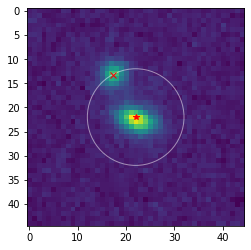

In [ ]:
show_galaxy_number = 1
# the center of galaxies should lie on the boundary of this rectangle
plt.imshow(ssi_galaxies[show_galaxy_number, 2])  # showing only i band


ax = plt.gca()

circle = plt.Circle(
    (stamp_pixel_size // 2, stamp_pixel_size // 2),
    pixel_shift_distance,
    color="white",
    fill=False,
    alpha=0.5,
)

ax.add_patch(circle)

plt.plot(
    blend.catalog_list[show_galaxy_number]["x_peak"],
    blend.catalog_list[show_galaxy_number]["y_peak"],
    marker="x",
    color="r",
)


plt.plot(stamp_pixel_size // 2, stamp_pixel_size // 2, marker="*", color="r");